# **Practice lab : Optimize your training process**

## Introduction

This Lab takes place as a pratical exercice of the [fidle](https://fidle.cnrs.fr/) online course N°16.


The goal of this notebook is to go through a typical deep learning model training. We will see what can be changed to optimize this training setup but also good practices to make more efficient experiments.


This notebook makes use of:
- The CIFAR10 dataset
- A Resnet model
- Pytorch
- A GPU (the notebook can be ran on Jean-Zay if you have an account, on Google collab with a 16go gpu or at home with a dedicated gpu by scaling down the batch_size)

In particular we will work on:
- the dataloader strategy used to load data
- the model initial weights, in particular using a pretrained model
- the learning rate and learning rate scheduler
- the optimizer
- visualizing and comparing results using python, tensorboard
- various good practices/reminders

> First, you can do a complete execution of the notebook.

> **Then comeback from the start and follow the instructions to edit various components for better performance. You can also change them during the first execution if you have some intuitions about what should be changed and how.**

> **In order to compare performance, only change the xxx_optim variables which are the one you will use in your optimized training**

In [1]:
#!nvidia-smi

## Few imports

In [2]:
import os
import time
import random
import numpy as np

import torch
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import _LRScheduler

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights

import matplotlib.pyplot as plt

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

/Users/dagoret/anaconda3/envs/fidle23/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/dagoret/anaconda3/envs/fidle23/lib/python3.9/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: /Users/dagoret/anaconda3/envs/fidle23/lib/python3.9/site-packages/torchvision/image.so
  Reason: image not found
  warn(f"Failed to load image Python extension: {e}")


## Fix random seeds
In order to have experiment reproductibility, it is a good practice to fix the random number generators seeds.

Warning : there might be more seeds to set than you expect! Maths,visualization,transformations libraries, ...

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Some functions

Below we define a few functions that will be used further in the notebook. 

**Do not change them unless you know what and why you are doing it.**

In [4]:
def iter_dataloader(dataloader, epochs, args):
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(dataloader):
            # distribution of images and labels to all GPUs
            images = images.to(args['device'], non_blocking=True)
            labels = labels.to(args['device'], non_blocking=True)
            
def evaluate(dataloader, model, criterion, args):
    '''
    A simple loop for evaluation
    '''
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            # distribution of images and labels to all GPUs
            images = images.to(args['device'], non_blocking=True)
            labels = labels.to(args['device'], non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs,labels)
            _, predicted = torch.max(outputs.data, 1)

            loss += loss
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = (loss/total).item()
    accuracy = (correct/total)*100
    return loss, accuracy

def train_default(train_loader, val_loader, model, optimizer, criterion, args):
    '''
    The default simple training loop
    '''
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    time_start = time.time()
    for epoch in range(args['epochs']):
        print("Epoch ", epoch)
        for i, (images, labels) in enumerate(train_loader):
            # distribution of images and labels to all GPUs
            images = images.to(args['device'], non_blocking=True)
            labels = labels.to(args['device'], non_blocking=True)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

        # Evaluate at the end of the epoch on the train set
        train_loss, train_accuracy = evaluate(train_loader, model, criterion, args)
        print("\t Train loss : ", train_loss, "& Train accuracy : ", train_accuracy)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)                
                
        # Evaluate at the end of the epoch on the val set
        val_loss, val_accuracy = evaluate(val_loader, model, criterion, args)
        print("\t Validation loss : ", val_loss, "& Validation accuracy : ", val_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
    duration = time.time() - time_start
    print('Finished Training in:', duration, 'seconds with mean epoch duration:', duration/args['epochs'], ' seconds')
    results = {'model':model,
               'train_losses': train_losses,
               'train_accuracies': train_accuracies,
               'val_losses': val_losses,
               'val_accuracies': val_accuracies,
               'duration':duration}
    return results

def explore_lrs(dataloader, 
                model, 
                optimizer,
                args,
                min_learning_rate_power=-8, 
                max_learning_rate_power = 1,
                num_lrs=10,
                steps_per_lr=50):
  
    lrs = np.logspace(min_learning_rate_power, max_learning_rate_power, num=num_lrs)
    print("Learning rate space : ", lrs)
    model_init_state = model.state_dict()

    lrs_losses, lrs_metric_avg, lrs_metric_var =[], [],[]
  
    # Iterate through learning rates to test
    for lr in lrs:
        print("Testing lr:", '{:.2e}'.format(lr))
        # Reset model
        model.load_state_dict(model_init_state)

        # Change learning rate in optimizer
        for group in optimizer.param_groups:
            group['lr'] = lr

        # Reset metric tracking
        lr_losses =[]

        # Training steps
        for step in range(steps_per_lr):
            images, labels = next(iter(dataloader))
            # distribution of images and labels to all GPUs
            images = images.to(args['device'], non_blocking=True)
            labels = labels.to(args['device'], non_blocking=True)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            lr_losses.append(loss.item())
        print(lr_losses)

        # Compute loss average for lr
        lr_loss_avg = np.mean(lr_losses) 
        lr_loss_avg = lr_losses[-1]

        lrs_losses.append(lr_loss_avg)

        # Compute metric (discounted average gradient of the loss)
        lr_gradients = np.gradient(lr_losses)
        lr_metric_avg = np.mean(lr_gradients)
        lr_metric_var = np.var(lr_gradients)
        lrs_metric_avg.append(lr_metric_avg)    
        lrs_metric_var.append(lr_metric_var)
        model.load_state_dict(model_init_state)

    return lrs, lrs_losses, lrs_metric_avg, lrs_metric_var

def plot_eval(lrs, lrs_losses, lrs_metric_avg, lrs_metric_var):
    print("lrs: ", lrs)
    print("lrs_losses: ", lrs_losses)
    print("lrs_metric_avg: ", lrs_metric_avg)
    print("lrs_metric_var: ", lrs_metric_var)
    fig, axs = plt.subplots(3, figsize=(10,15))

    axs[0].plot(lrs, lrs_losses, color='blue', label="losses_avg")
    axs[0].set_xlabel('learning rate', fontsize=15)
    axs[0].set_ylabel('Loss', fontsize=15)
    axs[0].set_xscale('log')
    axs[0].set_yscale('symlog')
    axs[0].set_ylim([0,  min(lrs_losses)*100])

    axs[1].plot(lrs, lrs_metric_avg, color='red', label="discounted_metric_avg")
    axs[1].hlines(y=0, xmin=lrs[0], xmax=lrs[-1], linewidth=2, color='black')
    axs[1].set_xlabel('learning rate', fontsize=15)
    axs[1].set_ylabel('Metric average', fontsize=15)
    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog')
    axs[1].set_ylim([-abs(lrs_metric_avg[0])*100, abs(lrs_metric_avg[0])*100])

    axs[2].plot(lrs, lrs_metric_var, color='green', label="discounted_metric_var")
    axs[2].set_xlabel('learning rate', fontsize=15)
    axs[2].set_ylabel('Metric variance', fontsize=15)
    axs[2].set_xscale('log')
    axs[2].set_yscale('symlog')
    axs[2].set_ylim([0, min(lrs_metric_var)*1000])

    plt.show()
    
def compare_trainings(results_default, results_optim):
    fig, axs = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Performance comparison', fontsize=18)    
    
    train_alpha = 0.5
    
    # Validation losses    
    axs[0].plot(range(len(results_default['val_losses'])), results_default['val_losses'], color='blue', label="default val")
    axs[0].plot(range(len(results_optim['val_losses'])), results_optim['val_losses'], color='red', label="optim val")

    # Training losses    
    axs[0].plot(range(len(results_default['train_losses'])), results_default['train_losses'], color='blue', label="default train", linestyle='--', alpha = train_alpha)
    axs[0].plot(range(len(results_optim['train_losses'])), results_optim['train_losses'], color='red', label="optim train", linestyle='--', alpha = train_alpha)
       
    axs[0].set_xlabel('Epochs', fontsize=14)
    axs[0].set_ylabel('Loss', fontsize=14)
    axs[0].set_xscale('linear')
    axs[0].set_yscale('linear')
    max_loss = max(results_default['train_losses']+results_default['val_losses']+results_optim['train_losses']+results_optim['val_losses'])
    axs[0].set_ylim([0,  max_loss])
    axs[0].legend(loc="upper right")
    
    # Validation accuracies
    axs[1].plot(range(len(results_default['val_accuracies'])), results_default['val_accuracies'], color='blue', label="default val")
    axs[1].plot(range(len(results_optim['val_accuracies'])), results_optim['val_accuracies'], color='red', label="optim val")

    # Training default accuracies
    axs[1].plot(range(len(results_default['train_accuracies'])), results_default['train_accuracies'], color='blue', label="default train", linestyle='--', alpha=train_alpha)
    axs[1].plot(range(len(results_optim['train_accuracies'])), results_optim['train_accuracies'], color='red', label="optim train", linestyle='--', alpha=train_alpha)
    
    axs[1].set_xlabel('Epochs', fontsize=15)
    axs[1].set_ylabel('Accuracy', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylim([0,  100])
    axs[1].legend(loc="lower right")

## Training configuration variables
For the first run, you can let all the values given by default.
For the optimized run, you could changing some parameters. 
>In particular, you will have to change :
>- the batch_size
>- the learning rate

In [5]:
args = {
    'batch_size':64,
    'epochs': 10,
    'image_size': 224,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'weight_decay': 0.0001,
    'download': True,
    'device': torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    'dataset_root_dir': os.getcwd(),
}

#################################################
############# Modify the code below #############
#################################################
args_optim = {
    'batch_size':64,
    'epochs': 10,
    'image_size': 224,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'weight_decay': 0.0001,
    'download': True,
    'device': torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    'dataset_root_dir': os.getcwd(), 
}

<details>
<summary>Spoiler (click to reveal)</summary>

```python
args_optim = {
    'batch_size':512,
    'epochs': 10,
    'image_size': 224,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'weight_decay': 0.01,
    'download': True,
    'device': torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    'dataset_root_dir': os.getcwd(), 
}
```    
</details>

## Data transformation and augmentation
Below, we define the transformations to apply to each image when loaded.
It can serve three main purposes:
- having the data in the desired format for the model (systematic transformation)
- correcting/normalizing the data (systematic transformation)
- artificially increasing the amount of data by transforming the data  (random transformation)

Warning : the evaluation dataset should always be the same so you should not apply random transformations to it.

> Enrich the transformations by using the provided by torchvision : https://pytorch.org/vision/0.12/transforms.html

> **Change transform_optim and val_transform_optim only**

In [6]:
transform = transforms.Compose([transforms.ToTensor()])     # convert the PIL Image to a tensor
val_transform = transforms.Compose([transforms.ToTensor()]) # convert the PIL Image to a tensor
                
#################################################
############# Modify the code below #############
#################################################
transform_optim = transforms.Compose([transforms.ToTensor()])     # convert the PIL Image to a tensor
val_transform_optim = transforms.Compose([transforms.ToTensor()]) # convert the PIL Image to a tensor

<details>
<summary>Spoiler</summary>

    
```python
transform_optim = transforms.Compose([ 
    transforms.RandomHorizontalFlip(),              # Horizontal Flip - Data Augmentation
    transforms.ToTensor()                          # convert the PIL Image to a tensor
    ])

val_transform_optim = transforms.Compose([
                transforms.ToTensor()                           # convert the PIL Image to a tensor
                ])
```    
</details>

## Dataset
In the cell below, we define the dataset.
Here we have two subset:
- a training subset for model optimization
- a test subset for model evaluation

In [7]:
train_dataset = torchvision.datasets.CIFAR10(root=args['dataset_root_dir']+'/CIFAR_10', train=True, download=args['download'], transform=transform)

val_dataset = torchvision.datasets.CIFAR10(root=args['dataset_root_dir']+'/CIFAR_10', train=False, download=args['download'], transform=val_transform)

train_dataset_optim = torchvision.datasets.CIFAR10(root=args_optim['dataset_root_dir']+'/CIFAR_10', train=True, download=args_optim['download'], transform=transform_optim)

val_dataset_optim = torchvision.datasets.CIFAR10(root=args_optim['dataset_root_dir']+'/CIFAR_10', train=False, download=args_optim['download'], transform=val_transform_optim)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /Users/dagoret/MacOSX/Fidle2023/fidle-tp/TPsupp/CIFAR_10/cifar-10-python.tar.gz to /Users/dagoret/MacOSX/Fidle2023/fidle-tp/TPsupp/CIFAR_10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Dataloader
The DataLoader class in PyTorch is responsible for loading and batching data from a dataset object, such as a PyTorch tensor or a NumPy array.
It works by creating a Python iterable over the dataset and yielding a batch of data at each iteration.

Those batches will be fed to the model for training or inference.

The DataLoader class also provides various options for shuffling, batching, and parallelizing the data loading process, making it a useful tool for efficient and flexible data handling in PyTorch.
> Take a look at the DataLoader documentation : https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

> Optimize the dataloader by taking advantage of parallelism and smart use of computational ressources :
>- batch_size
>- pin_memory
>- prefetch_factor 
>- persistent_workers 
>- num_workers

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args['batch_size'],
                                           shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,    
                                         batch_size=args['batch_size'],
                                         shuffle=False,
                                         drop_last=True)

#################################################
############# Modify the code below #############
#################################################
train_loader_optim = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args_optim['batch_size'],
                                           shuffle=True,
                                           drop_last=True)

val_loader_optim = torch.utils.data.DataLoader(dataset=val_dataset,    
                                         batch_size=args_optim['batch_size'],
                                         shuffle=False,
                                         drop_last=True)


In [9]:
%timeit -r 1 -n 1 iter_dataloader(train_loader, 1, args)
%timeit -r 1 -n 1 iter_dataloader(train_loader_optim, 1, args_optim)

28.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
26.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<details>
<summary>Spoiler</summary>
WIP : Quelques explications

```python
train_loader_optim = torch.utils.data.DataLoader(dataset=train_dataset_optim,
                                                 batch_size=args_optim['batch_size'],
                                                 shuffle=True,
                                                 drop_last=True,
                                                 num_workers=10,
                                                 persistent_workers=True,
                                                 pin_memory=True,
                                                 prefetch_factor=10)

val_loader_optim = torch.utils.data.DataLoader(dataset=val_dataset_optim,    
                                               batch_size=args_optim['batch_size'],
                                               shuffle=False,
                                               drop_last=True,
                                               num_workers=10,
                                               persistent_workers=True,
                                               pin_memory=True,
                                               prefetch_factor=10)
```    
</details>

## Model

> Do not forget to verify that you use the right compute ressources for your model

> By default, the model resnet18 is initialized with random weights but you could try using a pretrained model : https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights

In [10]:
model = models.resnet18()
model = model.to(args['device'])
model.name = 'Resnet-18'
print("Stock model on device:", next(model.parameters()).device)
#################################################
############# Modify the code below #############
#################################################
model_optim = models.resnet18()
model_optim = model_optim.to(args_optim['device'])
model_optim.name = 'Resnet-18'
print("Optimized model on device:", next(model_optim.parameters()).device)

Stock model on device: cpu
Optimized model on device: cpu


<details>
<summary>Spoiler</summary>
    
```python
model_optim = models.resnet18(ResNet18_Weights)
model_optim = model_optim.to(args_optim['device'])
model_optim.name = 'Resnet-18'
print("Optimized model on device:", next(model_optim.parameters()).device)
```    
</details>

## Loss
We use a standart loss for classification.

For the comparison, if you change the loss, change it for both.


In [11]:
criterion = torch.nn.CrossEntropyLoss()
criterion_optim = torch.nn.CrossEntropyLoss()

## Optimizer

> In order to speed up the training, you can try to use a different optimizer: https://pytorch.org/docs/stable/optim.html#base-class

In [12]:
optimizer = torch.optim.SGD(model.parameters(), args['learning_rate'], args['momentum'], args['weight_decay'])
#################################################
############# Modify the code below #############
#################################################
optimizer_optim = torch.optim.SGD(model.parameters(), args_optim['learning_rate'], args_optim['momentum'], args_optim['weight_decay'])

<details>
<summary>Spoiler</summary>

```python
optimizer_optim = torch.optim.AdamW(model_optim.parameters(), lr = args_optim['learning_rate'], weight_decay=args_optim['weight_decay'])
```
</details>

## Learning rate scheduler
In order to adjust the learning rate over iterations/epochs, we can make use of a learning rate scheduler.

To use a LR scheduler, you will need to :
- instantiate the scheduler (in the coding cell below)
- adapt the training loop (in the "Training" section)

Take a look at this page : https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate which: 
- describes how to use a scheduler (warning : some scheduler are updated at a step level and others at an epoch level)
- lists the available schedulers (you could also create your own starting from the _LRScheduler class)

> **You can define your scheduler here.**

> **You will have to modify the training loop later on.**

In [13]:
scheduler = None
#################################################
############# Modify the code below #############
#################################################
scheduler_optim = None

<details>
<summary>Spoiler</summary>
    
```python
scheduler_optim = torch.optim.lr_scheduler.OneCycleLR(optimizer_optim, 
                                                      max_lr=args_optim['learning_rate'], 
                                                      steps_per_epoch = len(train_loader_optim), 
                                                      epochs=args_optim['epochs'])
```    
</details>

## Model training (reference performances)
Once we have all our main actors, we can setup the stage that is our training loop.

Below is used a typical loop as you can find in https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
> **Run it a first time to have a performance baseline with all the default values.**

In [14]:
results_default = train_default(train_loader, val_loader, model, optimizer, criterion, args)

Epoch  0
	 Train loss :  5.272572525427677e-05 & Train accuracy :  53.75520166453265
	 Validation loss :  0.0002684388018678874 & Validation accuracy :  50.76121794871795
Epoch  1
	 Train loss :  4.1237090044887736e-05 & Train accuracy :  61.71174775928298
	 Validation loss :  0.00026081412215717137 & Validation accuracy :  56.58052884615385
Epoch  2
	 Train loss :  3.6135381378699094e-05 & Train accuracy :  68.06778169014085
	 Validation loss :  0.00023991975467652082 & Validation accuracy :  60.38661858974359
Epoch  3
	 Train loss :  2.7416836019256152e-05 & Train accuracy :  73.60755441741357
	 Validation loss :  0.0002622790343593806 & Validation accuracy :  62.630208333333336
Epoch  4
	 Train loss :  2.7480878998176195e-05 & Train accuracy :  76.7945742637644
	 Validation loss :  0.0002240049361716956 & Validation accuracy :  62.57011217948718
Epoch  5
	 Train loss :  2.3565260562463664e-05 & Train accuracy :  81.20598591549296
	 Validation loss :  0.0002684269566088915 & Validati

## Speeding up the hyperparameter search : Learning Rate Finder
Wether we are using a scheduler or not, we need to determine either : 
- the constant learning rate you want to use, 
- or the maximum learning rate used by the scheduler.

If you are in the first situation, you just want a good all-rounder learning rate to have a relatively fast conversion and minimize the oscillations at the end of the convergence.

In the second situation, you can focus more on having the fastest inital convergence as the oscillations will be generally taken care by a decreasing learning rate strategy. Thus, we want the highest maximum learning rate possible.

It would be ideal to find the best learning rate quickly in order to speedup our hyperparameter search.
Various strategy more or less complex exists to find an estimate of this value.
Below, we try to find the learning rate by doing a few steps on a range of learning rates. We evaluate each learning rate to determine the best one to choose for our full training.

> **As this step can take quite some time, we provided you with some values for the default config which you are not supposed to change anyway. You can find them in the next spoiler**

> **Uncomment explore_lrs to rerun the exploration, otherwise you can reuse the given values.**

> **Be careful to re-run this cell to reset the model and optimizer,...  to have a "fresh" exploration each time**

> **Also if you change the optimizer for the optimized run, change it also here to find the best learning rate for that optimizer.** Or rerun the cell where you defined it.

In [15]:
lrs, lrs_losses, lrs_metric_avg, lrs_metric_var = explore_lrs(train_loader_optim,
                                                              model_optim, 
                                                              optimizer_optim,
                                                              args_optim,
                                                              min_learning_rate_power=-6, 
                                                              max_learning_rate_power = 1,
                                                              num_lrs=8,
                                                              steps_per_lr=100) 

Learning rate space :  [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
Testing lr: 1.00e-06
[7.419761657714844, 7.593792915344238, 7.48207426071167, 7.374802112579346, 7.391928195953369, 7.41804838180542, 7.336314678192139, 7.395488739013672, 7.303165435791016, 7.398961067199707, 7.486789226531982, 7.360423564910889, 7.376132488250732, 7.339271545410156, 7.48701810836792, 7.397146224975586, 7.391808986663818, 7.309584617614746, 7.428520202636719, 7.360744476318359, 7.560018062591553, 7.4050397872924805, 7.262430667877197, 7.4990458488464355, 7.36317777633667, 7.544572830200195, 7.408862113952637, 7.48329496383667, 7.44195556640625, 7.5496978759765625, 7.39951229095459, 7.506143569946289, 7.440771579742432, 7.567551612854004, 7.421284198760986, 7.4644775390625, 7.459981441497803, 7.502686023712158, 7.553403854370117, 7.495738983154297, 7.304009914398193, 7.418666839599609, 7.464599132537842, 7.243458271026611, 7.343512058258057, 7.504941940307617, 7.456702709197998, 7.42218351

<details>
<summary>Spoiler</summary>
    
```python
lrs=[1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]
lrs_losses=  [7.502097129821777, 7.22658634185791, 5.24326229095459, 1.7600191831588745, 1.4037541151046753, 2.136382579803467, 2.1029751300811768, 446.49951171875]
lrs_metric_avg=[0.0017601490020751954, -0.005245075225830078, -0.041641921997070314, -0.07478624820709229, -0.007052739858627319, 0.04763659238815308, 0.03924872875213623, 9.939403522014619]
lrs_metric_var=[0.0006510000222988311, 0.0004144988674492198, 0.000668689274974986, 0.013876865854565344, 0.001481160611942387, 0.3384368026131311, 0.8817071610439394, 2157852536609.2454]
```    
</details>

lrs:  [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
lrs_losses:  [7.355217456817627, 7.284224510192871, 7.471691608428955, 7.562641620635986, 7.414772987365723, 7.483738899230957, 7.562841415405273, 7.4842939376831055]
lrs_metric_avg:  [3.929853439331055e-05, -0.002801673412322998, -0.0012024354934692383, 0.0025773024559020996, 0.0008704972267150879, 0.00032034158706665037, 0.003146228790283203, 0.0002505993843078613]
lrs_metric_var:  [0.0048708492957508205, 0.004597332155058502, 0.0038866995585178526, 0.0032975531412085895, 0.0037182111871910083, 0.0036459613379257634, 0.003773982038826626, 0.003676994569706375]


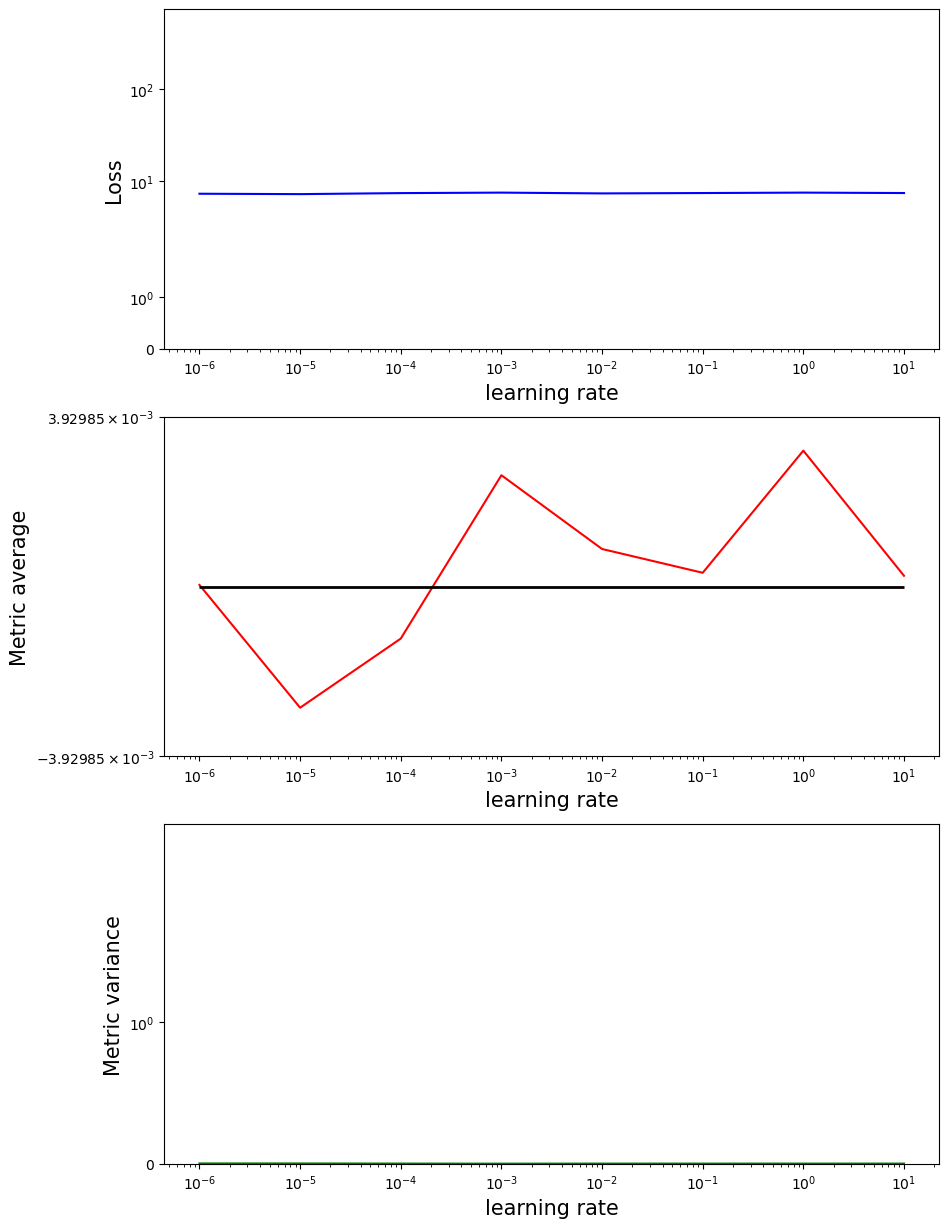

In [16]:
plot_eval(lrs, lrs_losses, lrs_metric_avg, lrs_metric_var)

## Optimize the training loop

> Adapt the dataset transformations, batch_size & dataloader, lr & lr_scheduler, and optimizer in order to achieve better classification results in less time. 

> Change this training loop to include:
> - a learning rate scheduler : https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
> - a strategy such as early stopping or patience : https://www.kaggle.com/code/akhileshrai/tutorial-early-stopping-vanilla-rnn-pytorch?scriptVersionId=26440051&cellId=10#4.-Early-Stopping

> **Also think about changing the call to the function if you added arguments.**

> For you, we added automatic mixed precision which will be seen in the next course

> **BEFORE RUNNING, WE NEED TO REINITIALIZE THE MODEL, OPTIMIZER AND SCHEDULER FOR A FAIR FIGHT. Rewrite below the changes you have brought to them.**

In [17]:
model_optim = models.resnet18().to(args_optim['device'])
model_optim.name = 'Resnet-18'
optimizer_optim = torch.optim.SGD(model_optim.parameters(), args_optim['learning_rate'], args_optim['momentum'], args_optim['weight_decay'])
scheduler_optim = None

In [18]:
def train_optim(train_loader, val_loader, model, optimizer, criterion, args):
    '''
    The default simple training loop
    '''
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    time_start = time.time()
    for epoch in range(args['epochs']):
        print("Epoch ", epoch)
        for i, (images, labels) in enumerate(train_loader):
            # distribution of images and labels to all GPUs
            images = images.to(args['device'], non_blocking=True)
            labels = labels.to(args['device'], non_blocking=True)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

        # Evaluate at the end of the epoch on the train set
        train_loss, train_accuracy = evaluate(train_loader, model, criterion, args)
        print("\t Train loss : ", train_loss, "& Train accuracy : ", train_accuracy)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)                
                
        # Evaluate at the end of the epoch on the val set
        val_loss, val_accuracy = evaluate(val_loader, model, criterion, args)
        print("\t Validation loss : ", val_loss, "& Validation accuracy : ", val_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    duration = time.time() - time_start
    print('Finished Training in:', duration, 'seconds with mean epoch duration:', duration/args['epochs'], ' seconds')
    results = {'model':model,
               'train_losses': train_losses,
               'train_accuracies': train_accuracies,
               'val_losses': val_losses,
               'val_accuracies': val_accuracies,
               'duration':duration}
    return results


<details>
<summary>Spoiler</summary>
    
```python
def train_optim(train_loader, val_loader, model, optimizer, criterion, scheduler, args):
    '''
    The default simple training loop
    '''
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    time_start = time.time()
    scaler = GradScaler()
    for epoch in range(args['epochs']):
        print("Epoch ", epoch)
        for i, (images, labels) in enumerate(train_loader):
            # distribution of images and labels to all GPUs
            images = images.to(args['device'], non_blocking=True)
            labels = labels.to(args['device'], non_blocking=True)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backward pass
            scaler.scale(loss).backward()
            
            # Optimize
            scaler.step(optimizer)
            
            # Updates the scale for next iteration.
            scaler.update()
            
            # Update Learning Rate scheduler, warning some schedulers are updated every epoch and not step.
            if scheduler is not None:
                scheduler.step()

        # Evaluate at the end of the epoch
        train_loss, train_accuracy = evaluate(train_loader, model, criterion, args)
        print("\t Train loss : ", train_loss, "& Train accuracy : ", train_accuracy)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)                
                
        # Evaluate at the end of the epoch
        val_loss, val_accuracy = evaluate(val_loader, model, criterion, args)
        print("\t Validation loss : ", val_loss, "& Validation accuracy : ", val_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    duration = time.time() - time_start
    print('Finished Training in:', duration, 'seconds with mean epoch duration:', duration/args['epochs'], ' seconds')
    results = {'model':model,
               'train_losses': train_losses,
               'train_accuracies': train_accuracies,
               'val_losses': val_losses,
               'val_accuracies': val_accuracies,
               'duration':duration}
    return results
```    
</details>

In [19]:
results_optim = train_optim(train_loader_optim, val_loader_optim, model_optim, optimizer_optim, criterion_optim, args_optim)

Epoch  0
	 Train loss :  4.531728336587548e-05 & Train accuracy :  53.385083226632524
	 Validation loss :  0.0002896013611461967 & Validation accuracy :  50.911458333333336
Epoch  1
	 Train loss :  5.035350477555767e-05 & Train accuracy :  61.75176056338029
	 Validation loss :  0.00027065956965088844 & Validation accuracy :  55.739182692307686
Epoch  2
	 Train loss :  3.234758332837373e-05 & Train accuracy :  68.18181818181817
	 Validation loss :  0.0002495504741091281 & Validation accuracy :  60.066105769230774
Epoch  3
	 Train loss :  3.380627094884403e-05 & Train accuracy :  73.6175576184379
	 Validation loss :  0.00024427520111203194 & Validation accuracy :  61.69871794871795
Epoch  4
	 Train loss :  2.1436522729345597e-05 & Train accuracy :  77.95894686299616
	 Validation loss :  0.0002375944604864344 & Validation accuracy :  63.34134615384615
Epoch  5
	 Train loss :  2.850788223440759e-05 & Train accuracy :  82.1842989756722
	 Validation loss :  0.0002554650418460369 & Validation

## Classification performances comparison

> Take a look at
>- the loss and accuracy evolution
>- the difference in timings between the two runs

In [20]:
print("Duration for default setup training:", results_default["duration"])
print("Duration for optim setup training:", results_optim["duration"])

Duration for default setup training: 6704.363262891769
Duration for optim setup training: 11686.926291942596


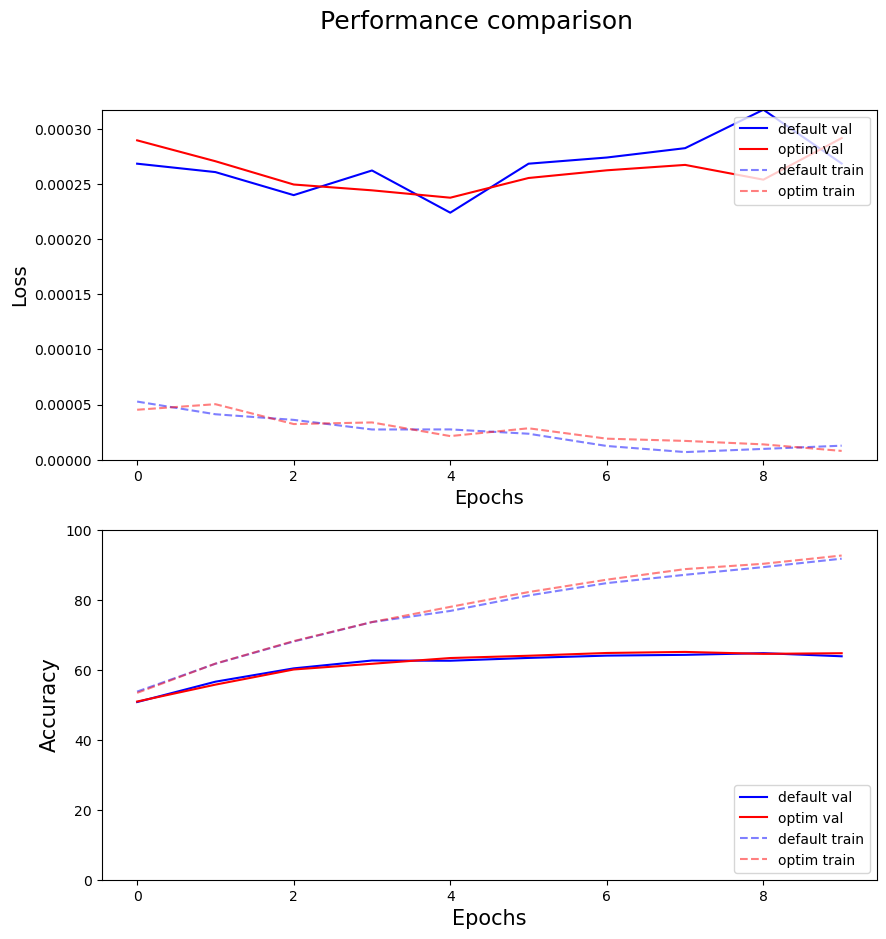

In [21]:
compare_trainings(results_default, results_optim)

## Tensorboard
Below we added a profiler and a logger for tensorboard. If you want to do it yourself in future codes, you can take example on the following documentations::
- Pytorch : https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html
- IDRIS : http://www.idris.fr/jean-zay/pre-post/jean-zay-tensorboard.html

> Try to add another metric to the logger, for example the validation loss at each epoch.

In [22]:
def train_default_tensorboard(train_loader, val_loader, model, optimizer, criterion, args, exp_name):
    log_dir = "./logs/"+exp_name
    writer = SummaryWriter(log_dir)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    time_start = time.time()
    with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(log_dir),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        for epoch in range(args['epochs']):
            print("Epoch ", epoch)
            for i, (images, labels) in enumerate(train_loader):
                # distribution of images and labels to all GPUs
                images = images.to(args['device'], non_blocking=True)
                labels = labels.to(args['device'], non_blocking=True)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Log a scalar (loss)
                writer.add_scalar("Loss/train", loss, i+epoch*len(train_loader))
                
                # Backward pass
                loss.backward()

                # Optimize
                optimizer.step()
                
                # Indicate to profiler when a step is over
                prof.step()
                
            # Evaluate at the end of the epoch on the train set
            train_loss, train_accuracy = evaluate(train_loader, model, criterion, args)
            print("\t Train loss : ", train_loss, "& Train accuracy : ", train_accuracy)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)                

            # Evaluate at the end of the epoch on the val set
            val_loss, val_accuracy = evaluate(val_loader, model, criterion, args)
            print("\t Validation loss : ", val_loss, "& Validation accuracy : ", val_accuracy)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
    duration = time.time() - time_start
    print('Finished Training in:', duration, 'seconds with mean epoch duration:', duration/args['epochs'], ' seconds')
    results = {'model':model,
               'train_losses': train_losses,
               'train_accuracies': train_accuracies,
               'val_losses': val_losses,
               'val_accuracies': val_accuracies,
               'duration':duration}
    return results

In [25]:
args["epochs"] = 1
_ = train_default_tensorboard(train_loader, val_loader, model, optimizer, criterion, args, "default_perf")

Epoch  0


[W collection.cpp:436] Warning: runpy.py(197): _run_module_as_main (function operator())
[W collection.cpp:436] Warning: runpy.py(87): _run_code (function operator())
[W collection.cpp:436] Warning: ipykernel_launcher.py(17): <module> (function operator())
[W collection.cpp:436] Warning: traitlets/config/application.py(1043): launch_instance (function operator())
[W collection.cpp:436] Warning: ipykernel/kernelapp.py(725): start (function operator())
[W collection.cpp:436] Warning: tornado/platform/asyncio.py(215): start (function operator())
[W collection.cpp:436] Warning: asyncio/base_events.py(601): run_forever (function operator())
[W collection.cpp:436] Warning: asyncio/base_events.py(1905): _run_once (function operator())
[W collection.cpp:436] Warning: asyncio/events.py(80): _run (function operator())
[W collection.cpp:436] Warning: ipykernel/kernelbase.py(513): dispatch_queue (function operator())
[W collection.cpp:436] Warning: ipykernel/kernelbase.py(502): process_one (functi

	 Train loss :  2.2615661237068707e-06 & Train accuracy :  95.07642445582587
	 Validation loss :  0.0003770703333429992 & Validation accuracy :  65.87540064102564
Finished Training in: 436.43792605400085 seconds with mean epoch duration: 436.43792605400085  seconds


In [26]:
# Load the TensorBoard notebook extension
#!pip install torch_tb_profiler
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 60313), started 0:28:25 ago. (Use '!kill 60313' to kill it.)